

## **Simpsons Classification**

This notebook is the part of the coursework from the Deep Learning School. The aim of this task was to train the model that can precisely name different Simpsons characters. Train and validation datasets contain 20933 labled images in total and test dataset - 991 unlabeled images. Total number of classes(characters) is 42. For evaluation f1 score was used

In [ ]:
!pip install wheel==0.34.1

In [ ]:


from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls -l /content/gdrive/MyDrive/simpsons/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 24 12:08 /content/gdrive/MyDrive/simpsons/journey-springfield.zip


In [ ]:
!unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip

In [ ]:
!ls -1

characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train


In [ ]:
!ls train
!ls testset

simpsons_dataset
testset


In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Nov 29 18:09:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from tqdm.autonotebook import tqdm, trange
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import time

from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler


/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# different dataset modes
DATA_MODES = ['train', 'val', 'test']
# scale to 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        
        self.files = sorted(files)

        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#TRAIN_DIR = Path('train/dataset')
#TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Dataset visualization

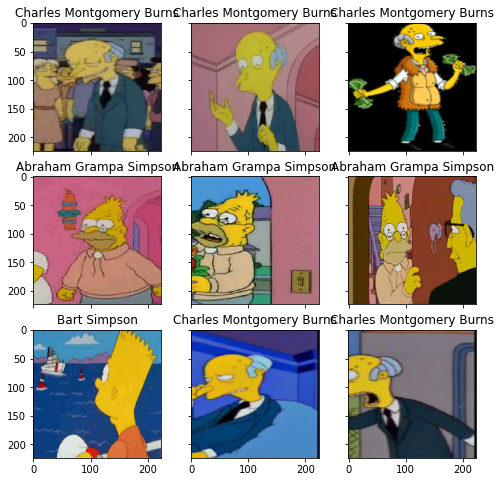

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Here we use transfer learning and vgg16 as pretrained model

In [ ]:

model_extractor = models.vgg16(pretrained=True)


for param in model_extractor.parameters():
    param.requires_grad = False


num_features = 25088

model_extractor.classifier = nn.Linear(num_features, 42)

if torch.cuda.is_available():
    model_extractor = model_extractor.cuda()


loss_fn = nn.CrossEntropyLoss()


optimizer_m = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_m, step_size=7, gamma=0.1)

### Building a CNN

Firstly let's do the easy one:

1. input size: 3x224x224 
2.size after 1 layer:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. output: 96x5x5


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step()        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, optimizer, scheduler, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            torch.save(model_extractor.state_dict(), f'{epoch}.pth')
            model_extractor.load_state_dict(torch.load(f'{epoch}.pth'))
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
#simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
#print(simple_cnn)

we will classify :42


Training the CNN

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
#train_dataset = SimpsonsDataset(train_files, mode='train')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
model_tun = models.vgg16(pretrained=True)

In [ ]:
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_tun.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if torch.cuda.is_available:
    model_tun = model_tun.cuda()

In [ ]:

history = train(train_dataset, val_dataset, model=model_extractor, epochs=20, optimizer=optimizer_m, scheduler= exp_lr_scheduler, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.4117712783573524

Epoch 001 train_loss: 1.4118     val_loss 0.9876 train_acc 0.6367 val_acc 0.7392
loss 0.3379950673726419

Epoch 002 train_loss: 0.3380     val_loss 0.8412 train_acc 0.9271 val_acc 0.7803
loss 0.1366819182857069

Epoch 003 train_loss: 0.1367     val_loss 0.8004 train_acc 0.9881 val_acc 0.7919
loss 0.07499144947071715

Epoch 004 train_loss: 0.0750     val_loss 0.7889 train_acc 0.9984 val_acc 0.7933
loss 0.05084239846496827

Epoch 005 train_loss: 0.0508     val_loss 0.7809 train_acc 0.9998 val_acc 0.7967
loss 0.03955050031650681

Epoch 006 train_loss: 0.0396     val_loss 0.7796 train_acc 0.9999 val_acc 0.7965
loss 0.0323299073844178

Epoch 007 train_loss: 0.0323     val_loss 0.7843 train_acc 1.0000 val_acc 0.7975
loss 0.02678709222616394

Epoch 008 train_loss: 0.0268     val_loss 0.7819 train_acc 1.0000 val_acc 0.7982
loss 0.026357589515094672

Epoch 009 train_loss: 0.0264     val_loss 0.7824 train_acc 1.0000 val_acc 0.7988
loss 0.0260083351529391

Epoch 010 train

Построим кривые обучения

In [ ]:
torch.save(model_extractor.state_dict(), 'VGG_20epoches.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('VGG_20epoches.pth'))

<All keys matched successfully>

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

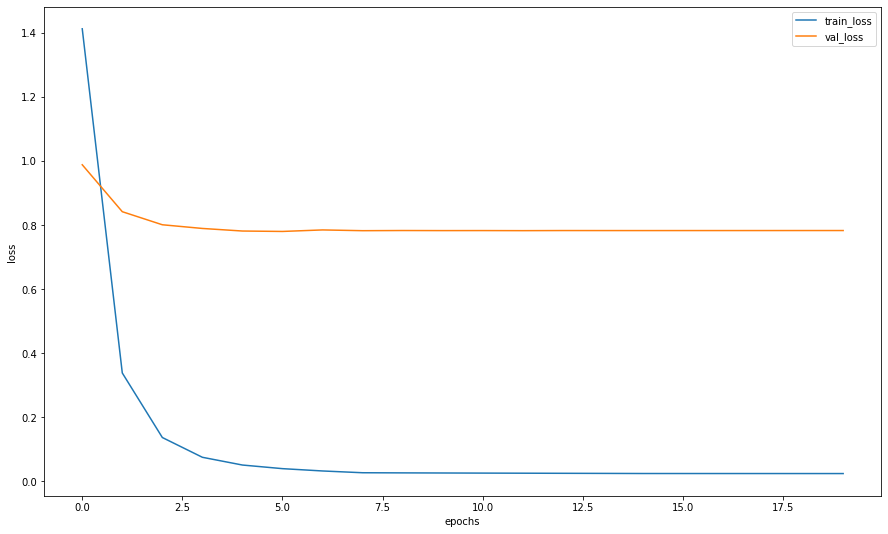

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):

    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

#actual_labels = [val_dataset[id][1] for id in idxs]
actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

So Final f1-score for validation dataset:

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class,average='micro')


0.8000000000000002

###Kaggle submission

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

0.pth	14.pth	19.pth	5.pth  characters_illustration.png  testset
10.pth	15.pth	1.pth	6.pth  gdrive			    train
11.pth	16.pth	2.pth	7.pth  label_encoder.pkl	    VGG_20epoches.pth
12.pth	17.pth	3.pth	8.pth  sample_data
13.pth	18.pth	4.pth	9.pth  sample_submission.csv


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
pd.read_csv('vgg20.csv')

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,homer_simpson
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [ ]:
my_submit.to_csv('gdrive/My Drive/simpsons/vgg20.csv', index=False)